In [1]:
import pandas as pd
import konlpy
import gensim

## 데이터 불러오기
- Train, Test 데이터

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

## Train 데이터 분석

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### info 메소드로 확인 결과
- 총 150000 데이터 중 document는 149995로 확인
- 결측치가 있는지 확인

In [6]:
# train데이터 중 document에 결측치가 있는지 확인
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [7]:
# 각각 확인해보기
train_data[train_data['id'].isnull()], train_data[train_data['label'].isnull()], train_data[train_data['document'].isnull()]

(Empty DataFrame
 Columns: [id, document, label]
 Index: [],
 Empty DataFrame
 Columns: [id, document, label]
 Index: [],
              id document  label
 25857   2172111      NaN      1
 55737   6369843      NaN      1
 110014  1034280      NaN      0
 126782  5942978      NaN      0
 140721  1034283      NaN      0)

In [8]:
# 중복 확인 3817개
train_data[train_data['document'].duplicated()]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


## 형태소 사전과 인코더-디코더 만들기
 
> KoNLPy의 형태소 분석 종류 ([🔗](https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html))
> - Hannanum: 한나눔. KAIST Semantic Web Research Center 개발.
    - http://semanticweb.kaist.ac.kr/hannanum/
> - Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발.
    - http://kkma.snu.ac.kr/
> - Komoran: 코모란. Shineware에서 개발.
    - https://github.com/shin285/KOMORAN
> - Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정.
    - https://bitbucket.org/eunjeon/mecab-ko
> - Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기.
    - https://github.com/open-korean-text/open-korean-text

#### 형태소 분석 선택 및 중복, 결측치 제거

In [9]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [10]:
# mecab 형태소 분석기 사용
# 불용어 정의
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [11]:
# drop_duplicates : 중복값 제거 (결측치 중복 포함 : 3817)
# dropna : 결측치 제거 (중복 제거 후 남은 결측치 : 1)
# 15000 - 3817 -1 = 146182
train_data_nonNa = train_data.drop_duplicates(subset=['document'])
train_data_nonNa = train_data_nonNa.dropna(how = 'any')
train_data_nonNa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### token화 및 불용어 처리

In [12]:
# tokenizer 처리 예시
def sentence2token(sentence):
    token = tokenizer.morphs(sentence)
    print('기본 : {}'.format(sentence))
    print('token화 : {}'.format(token))
    return token

# train에서 문장 하나 가져오기
sentence_num = 0
# token 생성
temp = sentence2token(sentence=train_data_nonNa.loc[sentence_num,"document"])
# 불용어 처리
temp = [word for word in temp if not word in stopwords]
print(f'불용어 처리 : {temp}')

기본 : 아 더빙.. 진짜 짜증나네요 목소리
token화 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
불용어 처리 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']


In [13]:
# train에 있는 모든 문장을 토큰화 및 불용어 제거 후 토큰 리스트 생성
X_train = []
for sentence in train_data_nonNa['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [14]:
# 토큰 리스트
print(X_train[:3])

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


#### 사전 정의

In [15]:
# X_train은 각 document에 존재하는 토큰이 리스트로 한차례 더 나눠져 있음 (2차원)
# 각 리스트에 존재하는 토큰을 하나의 리스트로 결합
words = np.concatenate(X_train).tolist()
print(len(words))

2336238


In [16]:
# list -> dict
counter = Counter(words)
print(len(counter))

53961


In [17]:
# 가장 많이 사용된 순으로 9996개 추출
counter = counter.most_common(10000-4)
print(len(counter))

9996


In [18]:
# 앞에 4개의 빈 원소가 있는 리스트를 추가
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
print(vocab[:10])

['<PAD>', '<BOS>', '<UNK>', '<UNUSED>', '.', '영화', '다', '고', '하', '을']


In [19]:
# '문자':인덱스 로 변환
word_to_index = {word:index for index, word in enumerate(vocab)}
print(len(word_to_index))

10000


In [20]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(index_to_word))

10000


In [21]:
# 각 리스트에 존재하는 단어를 숫자로 변환
# word_to_index에 없는 단어가 나오면 <UNK>:2으로 변환
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
train_X = list(map(wordlist_to_indexlist, X_train))

In [22]:
for a,b in zip(X_train[:5], train_X[:5]):
    print(f'원문 : {a}')
    print(f'변환 : {b}')

원문 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
변환 : [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
원문 : ['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나']
변환 : [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
원문 : ['너무', '재', '밓었다그래서보는것을추천한다']
변환 : [24, 205, 2]
원문 : ['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정']
변환 : [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
원문 : ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']
변환 : [2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]


In [23]:
# 문장 encode : str -> int
# 처음에 BOS 추가 및 모르는 단어 UNK로 변환
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in tokenizer.morphs(sentence)]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 문장 decode : int -> str
# <BOS>를 제외한 나머지 단어들을 decode (encoded_sentece[1:])
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [24]:
temp_a = get_encoded_sentence(train_data_nonNa.loc[0, 'document'], word_to_index=word_to_index)
print(temp_a)

[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [25]:
get_decoded_sentence(temp_a, index_to_word=index_to_word)

'아 더 빙 . . 진짜 짜증 나 네요 목소리'

### 변수 정리
- train_data, test_data : txt 원본 데이터
- train_data_nonNa : train_data에서 중복 및 결측치 제거
- tokenizer = Mecab() : Mecab 분석기를 사용하는 변수
- X_train : train_data에 있는 각 문장 리스트가 토큰으로 변환된 리스트
- words : X_train에 있는 모든 토큰의 리스트
- vocab : <PAD>, <BOS>, <UNK>, <UNUSED>를 추가한 사전 리스트
- word_to_index : 문자:인덱스 형태의 사전 dict
- index_to_word : 인덱스:문자 형태의 사전 dict
- train_X : X_train의 토큰이 숫자로 변형된 리스트

### 문장 길이 비교

In [26]:
num_tokens = [len(tokens) for tokens in X_train]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.98170773419436
문장길이 최대 :  116
문장길이 표준편차 :  12.82473766384545
pad_sequences maxlen :  41
전체 문장의 0.9341711017772366%가 maxlen 설정값 이내에 포함됩니다. 


## 데이터 전처리

#### train 데이터 전처리

In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
# train_data_nonNa에 있는 document 데이터를 모두 encode
x_train = get_encoded_sentences(train_data_nonNa.loc[:,'document'], word_to_index=word_to_index)

In [29]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen
)

In [30]:
x_train.shape

(146182, 41)

In [31]:
y_train = train_data_nonNa.loc[:,'label']

#### test 데이터 전처리

In [32]:
test_data.shape

(50000, 3)

In [33]:
def preprocess_data(data, word_to_index):
    # 중복 및 결측치 제거
    data = data.drop_duplicates(subset=['document'])
    data = data.dropna(how='any')
    print(data.shape)
    
    # train에서 사용한 word_to_index를 가져와 test 데이터에 적용
    x_data = get_encoded_sentences(data['document'] , word_to_index)

    return x_data, data.loc[:,'label']

In [34]:
x_test, y_test = preprocess_data(test_data, word_to_index)

(49157, 3)


In [35]:
get_decoded_sentences(x_test, index_to_word)[:5]

['굳 ㅋ',
 '<UNK>',
 '뭐 야 <UNK> 평점 <UNK> <UNK> . ... 나쁘 진 않 지만 10 점 짜리 <UNK> 더더욱 아니 잖아',
 '지루 하 지 <UNK> 않 은데 완전 막장 임 . .. 돈 주 고 보 기 <UNK> <UNK> . ...',
 '3 D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 <UNK> <UNK> 불편 하 게 하 죠 ? ?']

In [36]:
len(x_test), y_test.shape

(49157, (49157,))

In [37]:
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen
)

In [38]:
x_test.shape

(49157, 41)

## Model 학습

In [39]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(
    x_train, y_train, test_size=0.2, random_state=2000
)

In [40]:
results = {}
input_shape = x_train.shape[-1]
voca_size = len(word_to_index) # input_dim
word_vector_dim = 16 # 워드 벡터 차원 수 (output_dim)

input_shape, voca_size, word_vector_dim

(41, 10000, 16)

### 기본 Dense

In [41]:
def get_dense_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.Dense(40, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(10, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [42]:
dense_model = get_dense_model(input_shape, voca_size, word_vector_dim)
dense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 16)            160000    
_________________________________________________________________
dense (Dense)                (None, 41, 40)            680       
_________________________________________________________________
dropout (Dropout)            (None, 41, 40)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 41, 10)            410       
_________________________________________________________________
dense_2 (Dense)              (None, 41, 1)             11        
Total params: 161,101
Trainable params: 161,101
Non-trainable params: 0
_______________________________________________________

In [43]:
dense_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochs = 10
history_dense = dense_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = epochs,
    batch_size=256
)

Epoch 1/10
457/457 [==============================] - 4s 5ms/step - loss: 0.6800 - accuracy: 0.5368 - val_loss: 0.6753 - val_accuracy: 0.5373
Epoch 2/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6739 - accuracy: 0.5418 - val_loss: 0.6748 - val_accuracy: 0.5429
Epoch 3/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6733 - accuracy: 0.5431 - val_loss: 0.6748 - val_accuracy: 0.5428
Epoch 4/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6731 - accuracy: 0.5434 - val_loss: 0.6748 - val_accuracy: 0.5429
Epoch 5/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6730 - accuracy: 0.5434 - val_loss: 0.6748 - val_accuracy: 0.5429
Epoch 6/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6729 - accuracy: 0.5426 - val_loss: 0.6749 - val_accuracy: 0.5428
Epoch 7/10
457/457 [==============================] - 2s 5ms/step - loss: 0.6728 - accuracy: 0.5427 - val_loss: 0.6748 - val_accuracy: 0.5429
Epoch 

In [44]:
dense_loss, dense_acc = dense_model.evaluate(x_test,  y_test, verbose=2)
results['dense'] = {
    'loss': dense_loss,
    'acc': dense_acc
}
print(results['dense'])

1537/1537 - 3s - loss: 0.6747 - accuracy: 0.5446
{'loss': 0.6746910214424133, 'acc': 0.5445721745491028}


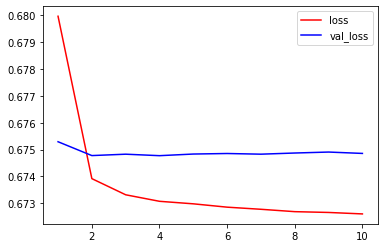

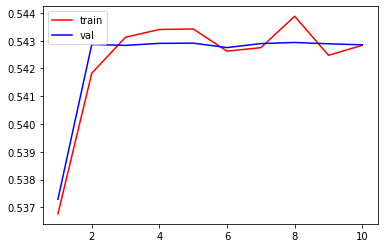

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), history_dense.history['loss'], 'r', label='loss')
plt.plot(range(1,epochs+1), history_dense.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), history_dense.history['accuracy'], 'r', label='train')
plt.plot(range(1,epochs+1), history_dense.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

### Conv1d Net

In [46]:
def get_conv_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.Conv1D(16, 5,activation='relu')(x)
    x = keras.layers.MaxPooling1D(3)(x)
    x = keras.layers.Conv1D(16, 5, activation='relu')(x)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(8, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [47]:
conv_model = get_conv_model(input_shape, voca_size, word_vector_dim)
conv_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 16)            1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 16)             1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0   

In [48]:
conv_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochs = 10
history = conv_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = epochs,
    batch_size=256
)

Epoch 1/10
457/457 [==============================] - 5s 5ms/step - loss: 0.5052 - accuracy: 0.7465 - val_loss: 0.3874 - val_accuracy: 0.8257
Epoch 2/10
457/457 [==============================] - 2s 5ms/step - loss: 0.3679 - accuracy: 0.8422 - val_loss: 0.3693 - val_accuracy: 0.8348
Epoch 3/10
457/457 [==============================] - 2s 5ms/step - loss: 0.3267 - accuracy: 0.8630 - val_loss: 0.3703 - val_accuracy: 0.8369
Epoch 4/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2939 - accuracy: 0.8781 - val_loss: 0.3769 - val_accuracy: 0.8355
Epoch 5/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2592 - accuracy: 0.8943 - val_loss: 0.4000 - val_accuracy: 0.8298
Epoch 6/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2283 - accuracy: 0.9079 - val_loss: 0.4301 - val_accuracy: 0.8285
Epoch 7/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2008 - accuracy: 0.9184 - val_loss: 0.4567 - val_accuracy: 0.8253
Epoch 

In [49]:
conv_loss, conv_acc = conv_model.evaluate(x_test,  y_test, verbose=2)

results['conv'] = {
    'loss': conv_loss,
    'acc': conv_acc
}
print(results['conv'])

1537/1537 - 2s - loss: 0.5582 - accuracy: 0.8188
{'loss': 0.5582380890846252, 'acc': 0.8187643885612488}


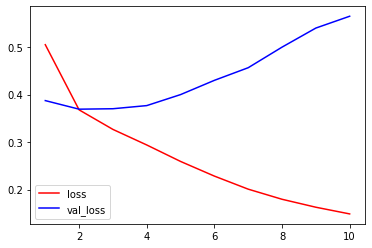

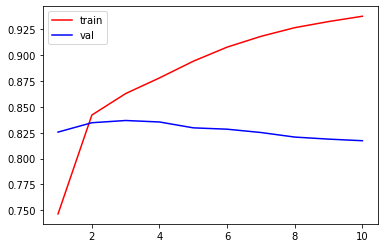

In [50]:
plt.plot(range(1,epochs+1), history.history['loss'], 'r', label='loss')
plt.plot(range(1,epochs+1), history.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), history.history['accuracy'], 'r', label='train')
plt.plot(range(1,epochs+1), history.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

### lstm

In [51]:
def get_lstm_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.LSTM(40)(x)
    x = keras.layers.Dropout(0.3)(x)
    x =keras.layers.Dense(10, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [52]:
lstm_model = get_lstm_model(input_shape, voca_size, word_vector_dim)
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 40)                9120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 169,541
Trainable params: 169,541
Non-trainable params: 0
_____________________________________________________

In [53]:
lstm_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochs = 10
history_lstm = lstm_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = epochs,
    batch_size=256
)

Epoch 1/10
457/457 [==============================] - 5s 6ms/step - loss: 0.4282 - accuracy: 0.8015 - val_loss: 0.3592 - val_accuracy: 0.8426
Epoch 2/10
457/457 [==============================] - 3s 5ms/step - loss: 0.3323 - accuracy: 0.8589 - val_loss: 0.3499 - val_accuracy: 0.8459
Epoch 3/10
457/457 [==============================] - 3s 6ms/step - loss: 0.3094 - accuracy: 0.8693 - val_loss: 0.3497 - val_accuracy: 0.8451
Epoch 4/10
457/457 [==============================] - 3s 5ms/step - loss: 0.2910 - accuracy: 0.8768 - val_loss: 0.3523 - val_accuracy: 0.8477
Epoch 5/10
457/457 [==============================] - 3s 6ms/step - loss: 0.2719 - accuracy: 0.8854 - val_loss: 0.3788 - val_accuracy: 0.8448
Epoch 6/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2523 - accuracy: 0.8931 - val_loss: 0.3948 - val_accuracy: 0.8463
Epoch 7/10
457/457 [==============================] - 3s 6ms/step - loss: 0.2347 - accuracy: 0.9012 - val_loss: 0.3861 - val_accuracy: 0.8460
Epoch 

In [54]:
lstm_loss, lstm_acc = lstm_model.evaluate(x_test,  y_test, verbose=2)

results['lstm'] = {
    'loss': lstm_loss,
    'acc': lstm_acc
}
print(results['lstm'])

1537/1537 - 3s - loss: 0.4730 - accuracy: 0.8435
{'loss': 0.4729917645454407, 'acc': 0.843521773815155}


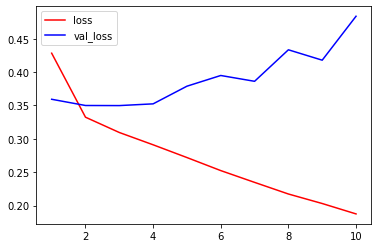

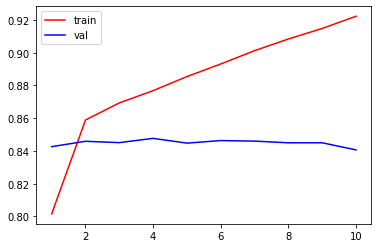

In [55]:
plt.plot(range(1,epochs+1), history_lstm.history['loss'], 'r', label='loss')
plt.plot(range(1,epochs+1), history_lstm.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), history_lstm.history['accuracy'], 'r', label='train')
plt.plot(range(1,epochs+1), history_lstm.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

In [56]:
results

{'dense': {'loss': 0.6746910214424133, 'acc': 0.5445721745491028},
 'conv': {'loss': 0.5582380890846252, 'acc': 0.8187643885612488},
 'lstm': {'loss': 0.4729917645454407, 'acc': 0.843521773815155}}

## Gensim 활용을 통한 비교 분석

### Custom Embedding Layer weights 저장

In [57]:
lstm_model.layers

In [58]:
# embedding Layer -> model.layers[1]
weights = lstm_model.layers[1].get_weights()[0]
print(weights)
weights.shape

[[-7.93196820e-03  5.43674119e-02 -5.59237935e-02 ... -3.76994908e-02
  -6.70441687e-02 -5.41359950e-05]
 [-4.12348052e-03  6.21793233e-02 -2.53869202e-02 ... -1.70458981e-04
  -7.67195374e-02 -2.42639687e-02]
 [ 2.37875450e-02 -1.70440471e-03  4.03237995e-03 ...  1.27259353e-02
   2.58721896e-02  1.51746022e-02]
 ...
 [-8.95325989e-02 -4.11467142e-02  1.04394086e-01 ... -1.44017994e-01
   1.70913473e-01 -1.13621958e-01]
 [-6.99587539e-02 -1.77281216e-01  2.41175786e-01 ... -1.85170081e-02
   1.62521973e-01 -2.00324669e-01]
 [ 9.90901291e-02  7.02453256e-02  8.32210630e-02 ...  1.31165192e-01
  -8.01883638e-02  1.56493872e-01]]


(10000, 16)

In [59]:
(lstm_model.get_weights()[0] == np.array(weights)).all()

True

In [60]:
custom_w2v_path = 'custom_w2v.txt'

# voca_size = 10000, word_vector_dim = 16
with open(custom_w2v_path, 'w') as f:
    # 사전에 정의된 수, 워드 벡터의 깊이 기록
    f.write('{} {}\n'.format(voca_size-4, word_vector_dim))
    
    # model의 임베딩 레이어 가중치 기록
    vectors = lstm_model.get_weights()[0] # lstm_model.layers[1].get_weights()[0]
    for i in range(4, voca_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i,:])))))

이후 다음과 같이 재사용 가능

In [61]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 
word_vectors = Word2VecKeyedVectors.load_word2vec_format(custom_w2v_path, binary=False)
vector = word_vectors['슬퍼']
vector.shape

(16,)

In [62]:
# 의미적 유사도가 가까운 것 출력
word_vectors.similar_by_word('슬퍼')

[('케미', 0.9612060189247131),
 ('돌아보', 0.9555216431617737),
 ('여운', 0.9496964812278748),
 ('재미있', 0.9477543830871582),
 ('들이', 0.9464307427406311),
 ('현기증', 0.9460894465446472),
 ('훌륭', 0.9449049830436707),
 ('최강희', 0.9424864053726196),
 ('훌쩍', 0.9424410462379456),
 ('쉰', 0.94022136926651)]

In [63]:
word_vectors.similar_by_word('행복')

[('센', 0.9639433026313782),
 ('희망', 0.9605365991592407),
 ('보냅니다', 0.9562159776687622),
 ('즐겼', 0.953188955783844),
 ('어염', 0.9496724009513855),
 ('강렬', 0.9481985569000244),
 ('좋', 0.948058009147644),
 ('명화', 0.9477666020393372),
 ('♥♥♥', 0.9471548199653625),
 ('지나갈', 0.9462836980819702)]

### pretrained 된 Word2Vector 가져오기

In [64]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [65]:
w2v_path = '/aiffel/data/word2vec_ko.model'
w2v_ko = Word2VecKeyedVectors.load(w2v_path)

In [66]:
ko_vector = w2v_ko.wv

In [67]:
ko_vector.most_similar('행복')

[('사랑', 0.7550067901611328),
 ('소중', 0.7270511388778687),
 ('고독', 0.7223575711250305),
 ('영원', 0.7196939587593079),
 ('친절', 0.7095474600791931),
 ('평온', 0.7088841199874878),
 ('삶', 0.6893891096115112),
 ('안녕', 0.6871559023857117),
 ('애틋', 0.6864286065101624),
 ('꿈', 0.6853601932525635)]

In [68]:
ko_vector.similar_by_word('슬퍼')

[('슬피', 0.7097666263580322),
 ('고마워', 0.6790604591369629),
 ('투정', 0.6726022958755493),
 ('안타까운', 0.6714802384376526),
 ('문득', 0.6714770197868347),
 ('차마', 0.6682374477386475),
 ('소리쳐', 0.6670060753822327),
 ('화났', 0.6648606657981873),
 ('두렵', 0.6606371998786926),
 ('무서워', 0.6601041555404663)]

### 키워드를 통한 두 word2vec 비교
- pretrained된 모델이 보다 유사한 단어를 잘 찾는다

In [69]:
ko_vector.most_similar('행복'), word_vectors.similar_by_word('행복')

([('사랑', 0.7550067901611328),
  ('소중', 0.7270511388778687),
  ('고독', 0.7223575711250305),
  ('영원', 0.7196939587593079),
  ('친절', 0.7095474600791931),
  ('평온', 0.7088841199874878),
  ('삶', 0.6893891096115112),
  ('안녕', 0.6871559023857117),
  ('애틋', 0.6864286065101624),
  ('꿈', 0.6853601932525635)],
 [('센', 0.9639433026313782),
  ('희망', 0.9605365991592407),
  ('보냅니다', 0.9562159776687622),
  ('즐겼', 0.953188955783844),
  ('어염', 0.9496724009513855),
  ('강렬', 0.9481985569000244),
  ('좋', 0.948058009147644),
  ('명화', 0.9477666020393372),
  ('♥♥♥', 0.9471548199653625),
  ('지나갈', 0.9462836980819702)])

In [70]:
ko_vector.most_similar('피곤'), word_vectors.similar_by_word('피곤')

([('답답', 0.8710565567016602),
  ('침울', 0.8464549779891968),
  ('불쾌', 0.8188039064407349),
  ('지루', 0.8179979920387268),
  ('지저분', 0.8096989393234253),
  ('허약', 0.7951755523681641),
  ('의아', 0.7921768426895142),
  ('난감', 0.7833302021026611),
  ('교만', 0.7797324657440186),
  ('쓸쓸', 0.779271125793457)],
 [('뇌', 0.9289692044258118),
  ('어야', 0.9010066390037537),
  ('망칠', 0.8874727487564087),
  ('극히', 0.8872160315513611),
  ('집어넣', 0.8837655782699585),
  ('소나', 0.8830259442329407),
  ('강혜정', 0.8799295425415039),
  ('살릴', 0.8790537118911743),
  ('이정재', 0.8784809112548828),
  ('.,', 0.8780664205551147)])

## pretrained 된 word2vector 사용하기

In [71]:
voca_size = 10000
word_vector_dim = ko_vector.vector_size
embedding_matrix = np.random.rand(voca_size, word_vector_dim)

In [72]:
for i in range(4,voca_size):
    if index_to_word[i] in ko_vector:
        embedding_matrix[i] = ko_vector[index_to_word[i]]

In [73]:
embedding_matrix.shape

(10000, 100)

In [74]:
from tensorflow.keras.initializers import Constant

In [75]:
def get_lstm_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(
            voca_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), trainable=True
        )(inputs)
    x = keras.layers.LSTM(100)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(10, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [76]:
print(voca_size, word_vector_dim)
lstm_model = get_lstm_model(input_shape, voca_size, word_vector_dim)
lstm_model.summary()

10000 100
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,081,421
Trainable params: 1,081,421
Non-trainable params: 0
_______________________________________

In [77]:
lstm_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochs = 10

history_lstm = lstm_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = epochs,
    batch_size=512
)

Epoch 1/10
229/229 [==============================] - 4s 12ms/step - loss: 0.4969 - accuracy: 0.7541 - val_loss: 0.4027 - val_accuracy: 0.8195
Epoch 2/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3738 - accuracy: 0.8345 - val_loss: 0.3569 - val_accuracy: 0.8426
Epoch 3/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3246 - accuracy: 0.8592 - val_loss: 0.3416 - val_accuracy: 0.8486
Epoch 4/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2969 - accuracy: 0.8742 - val_loss: 0.3380 - val_accuracy: 0.8542
Epoch 5/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2746 - accuracy: 0.8854 - val_loss: 0.3349 - val_accuracy: 0.8581
Epoch 6/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2555 - accuracy: 0.8947 - val_loss: 0.3289 - val_accuracy: 0.8596
Epoch 7/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2401 - accuracy: 0.9029 - val_loss: 0.3339 - val_accuracy: 0.8583

In [78]:
pre_lstm_loss, pre_lstm_acc = lstm_model.evaluate(x_test,  y_test, verbose=2)

results['pre_lstm'] = {
    'loss': pre_lstm_loss,
    'acc': pre_lstm_acc
}
print(results['pre_lstm'])

1537/1537 - 3s - loss: 0.3619 - accuracy: 0.8580
{'loss': 0.36191555857658386, 'acc': 0.8579856157302856}


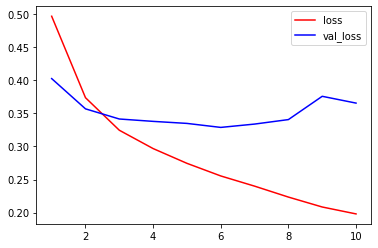

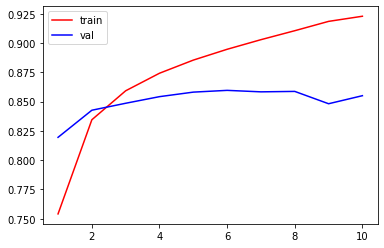

In [79]:
plt.plot(range(1,epochs+1), history_lstm.history['loss'], 'r', label='loss')
plt.plot(range(1,epochs+1), history_lstm.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), history_lstm.history['accuracy'], 'r', label='train')
plt.plot(range(1,epochs+1), history_lstm.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

In [80]:
results

{'dense': {'loss': 0.6746910214424133, 'acc': 0.5445721745491028},
 'conv': {'loss': 0.5582380890846252, 'acc': 0.8187643885612488},
 'lstm': {'loss': 0.4729917645454407, 'acc': 0.843521773815155},
 'pre_lstm': {'loss': 0.36191555857658386, 'acc': 0.8579856157302856}}

## 회고

### 이번 실험에 대한 생각
- Dense, Conv1d와 비교했을 때 lstm이 뛰어남
- 자체 제작된 word2vector와 pretrained word2vector 비교
    - pretrained가 더 similar한 단어를 잘 찾긴 했음
- pretrained된 word2vector를 lstm에 적용했을 때, 1% 정확도 향상이 있음
    - pretrained된 word2vector가 기준 단어와 유사한 단어를 찾는 걸 체감상 꽤나 잘 찾는 것에 비해 정확도에 큰 차이는 없음

### 알아간 것
- 다양한 모델 임의 제작
- word2vector 제작 방법
- konlpy, gensim 등 다양한 라이브러리 사용법 등